## Gabrielle Martinez   
## gm34308n@pace.edu   
Professor Kaltenberg   
ECO590 Seminar in Economic Theory   
16 October 2020   


In this Python Notebook, I'll be working on extracting data from the [PatentsView API](https://api.patentsview.org/assignee.html).

I'll be making a new variable called Specialization which would be the USPC code with the most patents in a given year for each firm.  
I plan on using a Difference in Differences model to study effects of the CAFE laws on the number of patents each firm creates (as a mark of innovation). So the first linear model would be for patents between 1972 and 1977, the second model would be for patents from 1978(year CAFE law was enforced) to 1987.

## Experimenting with the PatentsView API

I want assignee data and the number of patents per assignee per year. I'll start with the assignee version of API

#### Example Query URLs from the PatentsView [documentation](https://api.patentsview.org/assignee.html)
  
>Return the default fields for assignees on patents with a patent type of "utility", granted between 1999 and 2001, and whose title contains the word "Software".
https://api.patentsview.org/assignees/query?q={"_and":[{"patent_type":"utility"},{"_text_any":{"patent_title":"Software"}},{"_gte":{"patent_date":"1999-01-01"}},{"_lte":{"patent_date":"2001-12-31"}}]}

            
>Return the assignee types of all patents in NBER subcategory 22.
https://api.patentsview.org/assignees/query?q={"nber_subcategory_id":"22"}&f=["assignee_type"]

In [4]:
import ratelim
import tenacity
import requests
import pprint #pretty printing for json

import pandas as pd

Notes to self: 

uspc_num_patents_for_assignee (total # of catagory patents (not by year))

Check if year_num_patents_for_assignee changes when I focus on a subclass vs a whole class. If the number doesn't change then it might be a total for the comp (all patents for that year). Answer: its the later.


It seems that the assignee url version isn't what I'm looking for. I'm going to try to extract from the json, see what my output is as a dataframe. Then rework the url to get indivdual patents

In [4]:

#try to extract from json - see what my output is w/ assignees

#use this url for assignee info
url = ('https://api.patentsview.org/assignees/query?' #static part
      
        'q={'
           '"_and":['
               '{"uspc_subclass_id":["60/272","60/516","60/698","73/112","73/115","73/113","73/114"]}' #uspc subclass id/codes {"uspc_subclass_id":"60/39.01"}'
               ',{"_lte":{"patent_date":"1987-12-31"}}' #year of patent <= 1987
           ']}'
                  
        '&f=["assignee_organization","year_id","year_num_patents_for_assignee"]'#what fields to output
        '&o={"matched_subentities_only":"true","per_page":5}') # Only subentity data that matches the subentity specific criteria is included

print(url) 
print('\n')

https://api.patentsview.org/assignees/query?q={"_and":[{"uspc_subclass_id":["60/272","60/516","60/698","73/112","73/115","73/113","73/114"]},{"_lte":{"patent_date":"1987-12-31"}}]}&f=["assignee_organization","year_id","year_num_patents_for_assignee"]&o={"matched_subentities_only":"true","per_page":5}




In [165]:
#get method
response = requests.get(url)

#print any messages in case of error
print(f"{response.status_code}:{response.reason}")

#Parse `response.text` into JSON using json() function 
patent_assignees = response.json() 

#pretty print json
pp = pprint.PrettyPrinter(indent=1)
pp.pprint(patent_assignees)

print('\n')
print(patent_assignees['assignees'][1]['assignee_organization'])
print(len(patent_assignees['assignees']))

#loop through patent_assignees to get all assignee names
assignees=[]
years=[]

for k in range(len(patent_assignees['assignees'])):
    
    
    for i in range(len(patent_assignees['assignees'][k]['years'])):
        years.append(patent_assignees['assignees'][k]['years'][i])
        years_df = pd.DataFrame(years)
        
        assignees.append(patent_assignees['assignees'][k]['assignee_organization'])
        #assignees_df = pd.DataFrame(assignees)
        
    #can I add another col w/ assignee name repeating
        

    
print(assignees)
print(years)


#make into dataframe

#assignees_df

years_df["assignee"]=assignees

years_df

#https://www.geeksforgeeks.org/create-a-column-using-for-loop-in-pandas-dataframe/?ref=rp

200:OK
{'assignees': [{'assignee_organization': 'Automobiles Peugeot',
                'years': [{'year_id': '1978',
                           'year_num_patents_for_assignee': '13'}]},
               {'assignee_organization': 'Dr. Ing. h.c. F. Porsche '
                                         'Aktiengesellschaft',
                'years': [{'year_id': '1987',
                           'year_num_patents_for_assignee': '46'}]},
               {'assignee_organization': 'Deere & Company',
                'years': [{'year_id': '1984',
                           'year_num_patents_for_assignee': '116'},
                          {'year_id': '1985',
                           'year_num_patents_for_assignee': '110'}]},
               {'assignee_organization': 'General Motors Corporation',
                'years': [{'year_id': '1976',
                           'year_num_patents_for_assignee': '402'},
                          {'year_id': '1977',
                           'year_num_patents_f

,year_id,year_num_patents_for_assignee,assignee
0,1978,13,Automobiles Peugeot
1,1987,46,Dr. Ing. h.c. F. Porsche Aktiengesellschaft
2,1984,116,Deere & Company
3,1985,110,Deere & Company
4,1976,402,General Motors Corporation
5,1977,290,General Motors Corporation
6,1980,328,General Motors Corporation
7,1982,253,General Motors Corporation
8,1976,45,"Combustion Engineering, Inc."


## API - Patents Output

Before now, I've been using the assignees option for the API output. I'll be using the API to call all the patents for the following subclasses:

> 	Classes 60, 73, 123, 180, 701 and 903
	60/subclasses 272, 39.01, 516, and 698
	73/112-115
	Class 123
	180/subclasses 65.1 through 65.8
	701/subclasses 101, 103-110, 113, 123, and 29
	903/subclasses 902-927, 930, 940-948, 951, 952, and 960

    
Using list comprehension makes ints to strings from: https://www.geeksforgeeks.org/python-program-to-convert-list-of-integer-to-list-of-string/


In [154]:
#patents version of url

# url = ('https://api.patentsview.org/patents/query?' #static part
      
#         'q={'
#            '"_and":['     #uspc subclass id/codes
#                '{"uspc_subclass_id":["60/272","60/516","60/698","73/112","73/115","73/113","73/114","701/101","701/103"'
#                    ',"701/104","701/105","701/106","701/107","701/108","701/109","701/110","701/113","701/123","701/29"'
#                        #add more subclasses
#                    ']}' 
#                ',{"_lte":{"patent_date":"1987-12-31"}}' #year of patent <= 1987
#            ']}'
                  
#         '&f=["patent_year","uspc_subclass_id","assignee_type","assignee_id","inventor_id","assignee_organization","patent_number"]'#what fields to output
#         '&o={"matched_subentities_only":"true","per_page":5}') # Only subentity data that matches the subentity specific criteria is included

# print(url) 

In [198]:
# #automating range 903/subclasses 902-927
x = range(902,928) #902-927
y = range(940,949) #940-948

# Using list comprehension: make ints to strings
class903 = [str(n) for n in x] 
y = [str(n) for n in y]

#extra subclasses
x=["930","951","952","960"]

#add x to y
for i in range(len(x)):
    y.append(x[i])
#print(y)

#add y to class903
for i in range(len(y)):
    class903.append(y[i])

    
for i in range(len(class903)):
    if(i==len(class903)-1):
        class903[i] = '\"903/'+ class903[i] + '\"' #add 903/ w no ',' for the last of the list
    else:
        class903[i] = '\"903/'+ class903[i] + '\",' #add 903/ and ',' for all the rest
    
print(class903)


['"903/902",', '"903/903",', '"903/904",', '"903/905",', '"903/906",', '"903/907",', '"903/908",', '"903/909",', '"903/910",', '"903/911",', '"903/912",', '"903/913",', '"903/914",', '"903/915",', '"903/916",', '"903/917",', '"903/918",', '"903/919",', '"903/920",', '"903/921",', '"903/922",', '"903/923",', '"903/924",', '"903/925",', '"903/926",', '"903/927",', '"903/940",', '"903/941",', '"903/942",', '"903/943",', '"903/944",', '"903/945",', '"903/946",', '"903/947",', '"903/948",', '"903/930",', '"903/951",', '"903/952",', '"903/960"']


In [199]:
# x = range(902,928)

# x.append(3)

# # Using list comprehension: make ints to strings
# class903 = [str(n) for n in x] 

# #add 
# for i in range(len(class903)):
#     if(i==len(class903)-1):
#         class903[i] = '\"903/'+ class903[i] + '\"' #add 903/ w no ',' for the last of the list
#     else:
#         class903[i] = '\"903/'+ class903[i] + '\",' #add 903/ and ',' for all the rest
    
# print(class903[25])
# len(class903)


# first part of url
url = ('https://api.patentsview.org/patents/query?' #static part
      
        'q={'
           '"_and":['     #uspc subclass id/codes
               '{"uspc_subclass_id":["60/272","60/516","60/698","73/112","73/115","73/113","73/114","701/101","701/103"'
                   ',"701/104","701/105","701/106","701/107","701/108","701/109","701/110","701/113","701/123","701/29",')

#add class 903 subclasses

for i in range(len(class903)):
    url = url + class903[i]
    
#print(url)


#add rest of url
url_p2 = (']}' 
               ',{"_lte":{"patent_date":"1987-12-31"}}' #year of patent <= 1987
            ']}'
            '&f=["patent_year","uspc_subclass_id","assignee_type","assignee_id","inventor_id","assignee_organization","patent_number","assignee_country","assignee_state"]'
            '&o={"matched_subentities_only":"true","per_page":1000}'
         )

url = url + url_p2

print(url)


https://api.patentsview.org/patents/query?q={"_and":[{"uspc_subclass_id":["60/272","60/516","60/698","73/112","73/115","73/113","73/114","701/101","701/103","701/104","701/105","701/106","701/107","701/108","701/109","701/110","701/113","701/123","701/29","903/902","903/903","903/904","903/905","903/906","903/907","903/908","903/909","903/910","903/911","903/912","903/913","903/914","903/915","903/916","903/917","903/918","903/919","903/920","903/921","903/922","903/923","903/924","903/925","903/926","903/927","903/940","903/941","903/942","903/943","903/944","903/945","903/946","903/947","903/948","903/930","903/951","903/952","903/960"]},{"_lte":{"patent_date":"1987-12-31"}}]}&f=["patent_year","uspc_subclass_id","assignee_type","assignee_id","inventor_id","assignee_organization","patent_number","assignee_country","assignee_state"]&o={"matched_subentities_only":"true","per_page":1000}


The above url has most of the subclasses except: 
>Class 123   
180/subclasses 65.1 through 65.8   
60/39.01  

Decimal subclasses and full classes need to be queried seperately.    

NOTE TO SELF: change url to pull full dataset, not just the first 25 -> **Done. 553 patents**

In [200]:
#get method
response = requests.get(url) 

#print any messages in case of error
print(f"{response.status_code}:{response.reason}")

#parse into json
patents = response.json()

#pretty print json
pp = pprint.PrettyPrinter(indent=1)
pp.pprint(patents)

#full subclass query = 553 patents

200:OK
{'count': 553,
 'patents': [{'assignees': [{'assignee_country': 'US',
                             'assignee_id': 'org_WLFbXEQXv0uuNglpaujt',
                             'assignee_key_id': '405316',
                             'assignee_organization': 'Robertshaw Controls '
                                                      'Company',
                             'assignee_state': 'VA',
                             'assignee_type': '2'}],
              'inventors': [{'inventor_id': '3934417-1',
                             'inventor_key_id': '321348'},
                            {'inventor_id': '3934417-2',
                             'inventor_key_id': '321349'},
                            {'inventor_id': '3934417-3',
                             'inventor_key_id': '321350'},
                            {'inventor_id': '3934417-4',
                             'inventor_key_id': '321351'}],
              'patent_number': '3934417',
              'patent_year': '1976',
 

                             'assignee_organization': 'Nippon Soken, Inc.',
                             'assignee_state': None,
                             'assignee_type': '3'}],
              'inventors': [{'inventor_id': '3983369-1',
                             'inventor_key_id': '383295'},
                            {'inventor_id': '3983369-2',
                             'inventor_key_id': '383296'}],
              'patent_number': '3991727',
              'patent_year': '1976',
              'uspcs': [{'uspc_subclass_id': '701/104'}]},
             {'assignees': [{'assignee_country': 'JA',
                             'assignee_id': 'org_RfsqqmkbFTkrFXKfjR3X',
                             'assignee_key_id': '329040',
                             'assignee_organization': 'Daimler-Benz '
                                                      'Aktiengesellschaft',
                             'assignee_state': None,
                             'assignee_type': '3'}],
          

              'patent_year': '1977',
              'uspcs': [{'uspc_subclass_id': '903/914'},
                        {'uspc_subclass_id': '903/916'},
                        {'uspc_subclass_id': '903/918'}]},
             {'assignees': [{'assignee_country': 'DT',
                             'assignee_id': 'org_Xrxwlxzdisd5wBuRz364',
                             'assignee_key_id': '423181',
                             'assignee_organization': 'Robert Bosch GmbH',
                             'assignee_state': None,
                             'assignee_type': '3'}],
              'inventors': [{'inventor_id': '4039931-1',
                             'inventor_key_id': '438296'},
                            {'inventor_id': '4044234-1',
                             'inventor_key_id': '442209'}],
              'patent_number': '4044234',
              'patent_year': '1977',
              'uspcs': [{'uspc_subclass_id': '701/123'}]},
             {'assignees': [{'assignee_country': 'DT'

             {'assignees': [{'assignee_country': 'DE',
                             'assignee_id': 'org_UiBuoFDuSh7ttwIb101t',
                             'assignee_key_id': '374316',
                             'assignee_organization': 'Motoren-und '
                                                      'Turbinen-Union '
                                                      'Friedrichshafen GmbH',
                             'assignee_state': None,
                             'assignee_type': '3'}],
              'inventors': [{'inventor_id': '4086886-1',
                             'inventor_key_id': '478282'},
                            {'inventor_id': '4098077-2',
                             'inventor_key_id': '487256'},
                            {'inventor_id': '4098077-3',
                             'inventor_key_id': '487257'}],
              'patent_number': '4098077',
              'patent_year': '1978',
              'uspcs': [{'uspc_subclass_id': '60/272'}]},
    

                             'inventor_key_id': '375106'},
                            {'inventor_id': '3975952-3',
                             'inventor_key_id': '375107'},
                            {'inventor_id': '4106702-3',
                             'inventor_key_id': '494372'},
                            {'inventor_id': '4129034-2',
                             'inventor_key_id': '511859'}],
              'patent_number': '4129034',
              'patent_year': '1978',
              'uspcs': [{'uspc_subclass_id': '701/123'}]},
             {'assignees': [{'assignee_country': 'US',
                             'assignee_id': 'org_UxENMMIZvKLjwKOJAWEc',
                             'assignee_key_id': '381398',
                             'assignee_organization': 'RCA Corporation',
                             'assignee_state': 'NY',
                             'assignee_type': '2'}],
              'inventors': [{'inventor_id': '3965749-1',
                             'inv

                             'assignee_key_id': '142485',
                             'assignee_organization': 'Regie Nationale des '
                                                      'Usines Renault',
                             'assignee_state': None,
                             'assignee_type': '3'}],
              'inventors': [{'inventor_id': '4170040-1',
                             'inventor_key_id': '542863'},
                            {'inventor_id': '4170040-2',
                             'inventor_key_id': '542864'}],
              'patent_number': '4170040',
              'patent_year': '1979',
              'uspcs': [{'uspc_subclass_id': '701/123'},
                        {'uspc_subclass_id': '701/103'}]},
             {'assignees': [{'assignee_country': 'US',
                             'assignee_id': 'org_VVZs1rLGQVx2Bw6kriUk',
                             'assignee_key_id': '395493',
                             'assignee_organization': 'Clayton Mfg. Co.',


                             'assignee_state': 'CA',
                             'assignee_type': '2'}],
              'inventors': [{'inventor_id': '3997008-1',
                             'inventor_key_id': '397521'}],
              'patent_number': '4211291',
              'patent_year': '1980',
              'uspcs': [{'uspc_subclass_id': '60/698'}]},
             {'assignees': [{'assignee_country': 'US',
                             'assignee_id': 'org_6jWVXUock8hnH1uTSjxm',
                             'assignee_key_id': '47634',
                             'assignee_organization': 'The Bendix Corporation',
                             'assignee_state': 'MI',
                             'assignee_type': '2'}],
              'inventors': [{'inventor_id': '3960130-1',
                             'inventor_key_id': '356730'},
                            {'inventor_id': '3993939-2',
                             'inventor_key_id': '394483'},
                            {'inventor

                             'assignee_key_id': '47634',
                             'assignee_organization': 'The Bendix Corporation',
                             'assignee_state': 'MI',
                             'assignee_type': '2'}],
              'inventors': [{'inventor_id': '4244023-1',
                             'inventor_key_id': '596201'}],
              'patent_number': '4244023',
              'patent_year': '1981',
              'uspcs': [{'uspc_subclass_id': '701/110'},
                        {'uspc_subclass_id': '701/108'}]},
             {'assignees': [{'assignee_country': 'US',
                             'assignee_id': 'org_6jWVXUock8hnH1uTSjxm',
                             'assignee_key_id': '47634',
                             'assignee_organization': 'The Bendix Corporation',
                             'assignee_state': 'MI',
                             'assignee_type': '2'}],
              'inventors': [{'inventor_id': '4140088-1',
                  

                             'assignee_organization': 'The Bendix Corporation',
                             'assignee_state': 'MI',
                             'assignee_type': '2'}],
              'inventors': [{'inventor_id': '3964443-1',
                             'inventor_key_id': '361826'},
                            {'inventor_id': '4245314-3',
                             'inventor_key_id': '597162'}],
              'patent_number': '4276600',
              'patent_year': '1981',
              'uspcs': [{'uspc_subclass_id': '701/109'}]},
             {'assignees': [{'assignee_country': 'JP',
                             'assignee_id': 'org_yOSqt2KbCZQB2LRNpEKS',
                             'assignee_key_id': '436191',
                             'assignee_organization': 'Hitachi, Ltd.',
                             'assignee_state': None,
                             'assignee_type': '3'}],
              'inventors': [{'inventor_id': '3955273-1',
                        

             {'assignees': [{'assignee_country': 'JP',
                             'assignee_id': 'org_5vNXv1xWJ6aH9VmhCVri',
                             'assignee_key_id': '43058',
                             'assignee_organization': 'Nissan Motor Co., Ltd.',
                             'assignee_state': None,
                             'assignee_type': '3'}],
              'inventors': [{'inventor_id': '3949357-1',
                             'inventor_key_id': '342548'},
                            {'inventor_id': '4276866-1',
                             'inventor_key_id': '618935'}],
              'patent_number': '4319327',
              'patent_year': '1982',
              'uspcs': [{'uspc_subclass_id': '701/104'}]},
             {'assignees': [{'assignee_country': None,
                             'assignee_id': None,
                             'assignee_key_id': None,
                             'assignee_organization': None,
                             'assignee_s

                             'assignee_organization': None,
                             'assignee_state': None,
                             'assignee_type': None}],
              'inventors': [{'inventor_id': '4049145-1',
                             'inventor_key_id': '446458'}],
              'patent_number': '4347907',
              'patent_year': '1982',
              'uspcs': [{'uspc_subclass_id': '903/905'},
                        {'uspc_subclass_id': '903/916'}]},
             {'assignees': [{'assignee_country': 'JP',
                             'assignee_id': 'org_Qk7ZY773gg0j4nmTULIb',
                             'assignee_key_id': '316278',
                             'assignee_organization': 'Nippondenso Co., Ltd.',
                             'assignee_state': None,
                             'assignee_type': '3'}],
              'inventors': [{'inventor_id': '3961021-2',
                             'inventor_key_id': '357867'},
                            {'inven

                             'inventor_key_id': '616966'}],
              'patent_number': '4367530',
              'patent_year': '1983',
              'uspcs': [{'uspc_subclass_id': '701/108'}]},
             {'assignees': [{'assignee_country': None,
                             'assignee_id': None,
                             'assignee_key_id': None,
                             'assignee_organization': None,
                             'assignee_state': None,
                             'assignee_type': None}],
              'inventors': [{'inventor_id': '3994428-1',
                             'inventor_key_id': '394963'}],
              'patent_number': '4368509',
              'patent_year': '1983',
              'uspcs': [{'uspc_subclass_id': '701/123'}]},
             {'assignees': [{'assignee_country': None,
                             'assignee_id': None,
                             'assignee_key_id': None,
                             'assignee_organization': None,
  

                             'inventor_key_id': '402096'},
                            {'inventor_id': '4217486-2',
                             'inventor_key_id': '577497'}],
              'patent_number': '4410948',
              'patent_year': '1983',
              'uspcs': [{'uspc_subclass_id': '701/110'}]},
             {'assignees': [{'assignee_country': 'DE',
                             'assignee_id': 'org_X8GNqB5ljAsd8a4WLGC4',
                             'assignee_key_id': '414202',
                             'assignee_organization': 'Volkswagen AG',
                             'assignee_state': None,
                             'assignee_type': '3'}],
              'inventors': [{'inventor_id': '3931988-4',
                             'inventor_key_id': '317401'}],
              'patent_number': '4411171',
              'patent_year': '1983',
              'uspcs': [{'uspc_subclass_id': '903/910'},
                        {'uspc_subclass_id': '903/960'}]},
            

              'patent_year': '1984',
              'uspcs': [{'uspc_subclass_id': '701/101'}]},
             {'assignees': [{'assignee_country': 'DE',
                             'assignee_id': 'org_iJXrSOVr3tr03uKBa68c',
                             'assignee_key_id': '198300',
                             'assignee_organization': 'VDO Adolf Schindling AG',
                             'assignee_state': None,
                             'assignee_type': '3'}],
              'inventors': [{'inventor_id': '4241438-1',
                             'inventor_key_id': '594405'}],
              'patent_number': '4444047',
              'patent_year': '1984',
              'uspcs': [{'uspc_subclass_id': '701/123'}]},
             {'assignees': [{'assignee_country': None,
                             'assignee_id': None,
                             'assignee_key_id': None,
                             'assignee_organization': None,
                             'assignee_state': None,
     

              'inventors': [{'inventor_id': '3993037-3',
                             'inventor_key_id': '393568'},
                            {'inventor_id': '4033170-1',
                             'inventor_key_id': '432144'},
                            {'inventor_id': '4086773-1',
                             'inventor_key_id': '478180'},
                            {'inventor_id': '4111170-1',
                             'inventor_key_id': '497891'}],
              'patent_number': '4456831',
              'patent_year': '1984',
              'uspcs': [{'uspc_subclass_id': '701/113'}]},
             {'assignees': [{'assignee_country': 'JP',
                             'assignee_id': 'org_0eDis9QrietKKeULTT5r',
                             'assignee_key_id': '2267',
                             'assignee_organization': 'Toyota Jidosha '
                                                      'Kabushiki Kaisha',
                             'assignee_state': None,
               

             {'assignees': [{'assignee_country': 'SE',
                             'assignee_id': 'org_H9WN6Clp4w8wfssntJiI',
                             'assignee_key_id': '178844',
                             'assignee_organization': 'United Stirling AB',
                             'assignee_state': None,
                             'assignee_type': '3'}],
              'inventors': [{'inventor_id': '4457133-1',
                             'inventor_key_id': '736571'}],
              'patent_number': '4485627',
              'patent_year': '1984',
              'uspcs': [{'uspc_subclass_id': '60/698'}]},
             {'assignees': [{'assignee_country': 'US',
                             'assignee_id': 'org_M9yn63K24vPZ9NrEv2e6',
                             'assignee_key_id': '252975',
                             'assignee_organization': 'United Technologies '
                                                      'Corporation',
                             'assignee_state': '

              'patent_year': '1985',
              'uspcs': [{'uspc_subclass_id': '701/103'}]},
             {'assignees': [{'assignee_country': 'US',
                             'assignee_id': 'org_57TWP8DdNlXDF67NPtTo',
                             'assignee_key_id': '37560',
                             'assignee_organization': 'Deere & Company',
                             'assignee_state': 'IL',
                             'assignee_type': '2'}],
              'inventors': [{'inventor_id': '4537028-1',
                             'inventor_key_id': '788084'}],
              'patent_number': '4537028',
              'patent_year': '1985',
              'uspcs': [{'uspc_subclass_id': '60/272'}]},
             {'assignees': [{'assignee_country': 'JP',
                             'assignee_id': 'org_Qk7ZY773gg0j4nmTULIb',
                             'assignee_key_id': '316278',
                             'assignee_organization': 'Nippondenso Co., Ltd.',
                       

                             'inventor_key_id': '799673'}],
              'patent_number': '4554989',
              'patent_year': '1985',
              'uspcs': [{'uspc_subclass_id': '903/902'}]},
             {'assignees': [{'assignee_country': 'JP',
                             'assignee_id': 'org_0eDis9QrietKKeULTT5r',
                             'assignee_key_id': '2267',
                             'assignee_organization': 'Toyota Jidosha '
                                                      'Kabushiki Kaisha',
                             'assignee_state': None,
                             'assignee_type': '3'}],
              'inventors': [{'inventor_id': '3933307-2',
                             'inventor_key_id': '319563'},
                            {'inventor_id': '4175527-2',
                             'inventor_key_id': '546903'}],
              'patent_number': '4556033',
              'patent_year': '1985',
              'uspcs': [{'uspc_subclass_id': '701/109'}

             {'assignees': [{'assignee_country': 'US',
                             'assignee_id': 'org_s3Va7rSFzQFoRNnIsTRm',
                             'assignee_key_id': '339409',
                             'assignee_organization': 'Wayne State University',
                             'assignee_state': 'MI',
                             'assignee_type': '2'}],
              'inventors': [{'inventor_id': '4169011-1',
                             'inventor_key_id': '542083'},
                            {'inventor_id': '4340602-1',
                             'inventor_key_id': '661291'}],
              'patent_number': '4568673',
              'patent_year': '1986',
              'uspcs': [{'uspc_subclass_id': '701/113'}]},
             {'assignees': [{'assignee_country': 'FR',
                             'assignee_id': 'org_EQiAowmpAcw5pli4YOGe',
                             'assignee_key_id': '142485',
                             'assignee_organization': 'Regie Nationale de

              'patent_number': '4599694',
              'patent_year': '1986',
              'uspcs': [{'uspc_subclass_id': '701/103'}]},
             {'assignees': [{'assignee_country': 'US',
                             'assignee_id': 'org_NKsxikGVm2cvWxVCf6ze',
                             'assignee_key_id': '272459',
                             'assignee_organization': 'Motorola, Inc.',
                             'assignee_state': 'IL',
                             'assignee_type': '2'}],
              'inventors': [{'inventor_id': '4453514-2',
                             'inventor_key_id': '734198'}],
              'patent_number': '4599695',
              'patent_year': '1986',
              'uspcs': [{'uspc_subclass_id': '701/110'}]},
             {'assignees': [{'assignee_country': 'US',
                             'assignee_id': 'org_eLm3Hjw6PddtTnP0oZii',
                             'assignee_key_id': '140196',
                             'assignee_organization': 'Alli

                             'assignee_state': None,
                             'assignee_type': '3'}],
              'inventors': [{'inventor_id': '4336784-2',
                             'inventor_key_id': '658991'},
                            {'inventor_id': '4445482-2',
                             'inventor_key_id': '729009'}],
              'patent_number': '4636957',
              'patent_year': '1987',
              'uspcs': [{'uspc_subclass_id': '701/110'},
                        {'uspc_subclass_id': '701/108'}]},
             {'assignees': [{'assignee_country': None,
                             'assignee_id': None,
                             'assignee_key_id': None,
                             'assignee_organization': None,
                             'assignee_state': None,
                             'assignee_type': None}],
              'inventors': [{'inventor_id': '4531480-1',
                             'inventor_key_id': '784561'}],
              'patent_n

                             'assignee_type': '3'}],
              'inventors': [{'inventor_id': '3962866-3',
                             'inventor_key_id': '360045'},
                            {'inventor_id': '4166437-3',
                             'inventor_key_id': '540164'},
                            {'inventor_id': '4172505-3',
                             'inventor_key_id': '544727'},
                            {'inventor_id': '4180100-5',
                             'inventor_key_id': '550274'},
                            {'inventor_id': '4616618-1',
                             'inventor_key_id': '840415'}],
              'patent_number': '4674459',
              'patent_year': '1987',
              'uspcs': [{'uspc_subclass_id': '701/104'}]},
             {'assignees': [{'assignee_country': 'JP',
                             'assignee_id': 'org_cxgkrEYbEyIJWgEfjE8W',
                             'assignee_key_id': '116474',
                             'assignee_orga

                             'assignee_id': 'org_BgjeGVyguhbbET1HvVVT',
                             'assignee_key_id': '93709',
                             'assignee_organization': 'Mazda Motor Corporation',
                             'assignee_state': None,
                             'assignee_type': '3'}],
              'inventors': [{'inventor_id': '3969727-1',
                             'inventor_key_id': '368044'},
                            {'inventor_id': '4134376-1',
                             'inventor_key_id': '515994'},
                            {'inventor_id': '4345432-3',
                             'inventor_key_id': '664460'},
                            {'inventor_id': '4474008-2',
                             'inventor_key_id': '747306'}],
              'patent_number': '4699097',
              'patent_year': '1987',
              'uspcs': [{'uspc_subclass_id': '903/906'}]},
             {'assignees': [{'assignee_country': 'DE',
                          

In [201]:
#lets looks at the structure of the json
#print(patents['patents'][0]) #<-one instance

#loop through patents to get all patent instances
patent = []
years = []
assignees = []
inventors = []
assignee_id = []
uspcs = []

#need these to have similar columns to merge dfs
a_name=[]
p_num = []
p_num_2=[]

#NOTE: change assignee_organization to assignee_id

for k in range(len(patents['patents'])): #loop thru patents and append
    years.append(patents['patents'][k]['patent_year'])
#     patent.append(patents['patents'][k]['patent_number'])
    uspcs.append(patents['patents'][k]['uspcs'][0]['uspc_subclass_id'])
    
    years_df = pd.DataFrame(years) #years dataframe
    a_name.append(patents['patents'][k]['assignees'][0]['assignee_organization'])
    p_num.append(patents['patents'][k]['patent_number'])
    
#     assignees.append(patents['patents'][k]['assignees'])
#     assignees_df = pd.DataFrame(assignees)
    
    for i in range(len(patents['patents'][k]['assignees'])): #loop thru assignees and append
        assignees.append(patents['patents'][k]['assignees'][i])
        assignees_df = pd.DataFrame(assignees) #assignee dataframe
            
        patent.append(patents['patents'][k]['patent_number'])
        
        for x in range(len(patents['patents'][k]['inventors'])): #eww three for loops. n^3 complexity >.<
            
            inventors.append(patents['patents'][k]['inventors'][x]) #append inventor data
            inventors_df = pd.DataFrame(inventors) 
            assignee_id.append(patents['patents'][k]['assignees'][i]['assignee_organization']) #change this to assignee_id 
            
            p_num_2.append(patents['patents'][k]['patent_number'])
            #this for loop is to make the assignees repeat and correspond with the inventor ids
        

#print(patents['patents'][k]['assignees'][0]['assignee_organization'])        

#add columns to dataframes
inventors_df["assignee_organization"]=assignee_id
inventors_df["patent_number"]=p_num_2
inventors_df        


#print(assignees)
# print(years)
# print(patent)

#a_name


,inventor_id,inventor_key_id,assignee_organization,patent_number
0,3934417-1,321348,Robertshaw Controls Company,3934417
1,3934417-2,321349,Robertshaw Controls Company,3934417
2,3934417-3,321350,Robertshaw Controls Company,3934417
3,3934417-4,321351,Robertshaw Controls Company,3934417
4,3937017-1,325169,Maschinenfabrik Augsburg-Nurnberg Aktiengesell...,3937017
...,...,...,...,...
1273,3955273-1,350548,"Hitachi, Ltd.",RE32140
1274,3980832-1,380527,"Hitachi, Ltd.",RE32140
1275,4274141-1,616966,"Hitachi, Ltd.",RE32140
1276,4190027-4,557517,"Hitachi, Ltd.",RE32156


In [202]:
#add columns to dataframe
years_df["patent_number"]=p_num
years_df["uspc_subclass_id"]=uspcs
years_df["assignee_organization"]=a_name
years_df

#years_df['patent_number'].nunique() #25 unique patent numbers


,0,patent_number,uspc_subclass_id,assignee_organization
0,1976,3934417,60/516,Robertshaw Controls Company
1,1976,3937017,60/516,Maschinenfabrik Augsburg-Nurnberg Aktiengesell...
2,1976,3953715,701/123,Societe des Procedes Modernes d'Injection Sopromi
3,1976,3953716,701/123,Agence Nationale de Valorisation de la Recherc...
4,1976,3956895,60/516,The United States of America as represented by...
...,...,...,...,...
548,1978,RE29741,701/110,"Nippondenso Co., Ltd."
549,1985,RE31906,701/108,"Hitachi, Ltd."
550,1985,RE32030,701/110,"Nissan Motor Co., Ltd."
551,1986,RE32140,701/103,"Hitachi, Ltd."


In [203]:
#lets see assignees_df
assignees_df["patent_number"]=patent
assignees_df

,assignee_type,assignee_id,assignee_organization,assignee_country,assignee_state,assignee_key_id,patent_number
0,2,org_WLFbXEQXv0uuNglpaujt,Robertshaw Controls Company,US,VA,405316,3934417
1,3,org_d7Cgs8GkaSDEwmfFOL1Z,Maschinenfabrik Augsburg-Nurnberg Aktiengesell...,DT,None,119492,3937017
2,3,org_sojILSfE8Of4IhJtoUvH,Firma Motoren-Werke Mannheim Aktiengesellschaf...,DE,None,347790,3937017
3,3,org_Z8mWQfh54whRqC1GqzOM,Societe des Procedes Modernes d'Injection Sopromi,FR,None,443684,3953715
4,7,org_7IZPx0no0y4uuAMGwkei,Agence Nationale de Valorisation de la Recherc...,FR,None,54873,3953716
...,...,...,...,...,...,...,...
574,3,org_Qk7ZY773gg0j4nmTULIb,"Nippondenso Co., Ltd.",JP,None,316278,RE29741
575,3,org_yOSqt2KbCZQB2LRNpEKS,"Hitachi, Ltd.",JP,None,436191,RE31906
576,3,org_5vNXv1xWJ6aH9VmhCVri,"Nissan Motor Co., Ltd.",JP,None,43058,RE32030
577,3,org_yOSqt2KbCZQB2LRNpEKS,"Hitachi, Ltd.",JP,None,436191,RE32140


In [204]:
#lets look at our dfs (uncomment to see each)
#merged1
#inventors_df 
#years_df  
#assignees_df

#add assignee_key_id to years
# years_df["assignee_key_id"] = assignees_df[['assignee_key_id']]
# years_df["assignee_id"] = assignees_df[['assignee_id']]
# #years_df

#filter out nulls
# years_df = years_df[years_df['assignee_organization'].notnull()]
# years_df.isnull().sum()
# years_df

# #filter out nulls
# assignees_df = assignees_df[assignees_df['assignee_organization'].notnull()]
# assignees_df.isnull().sum()
# assignees_df

As a test, I only pulled the first 25 results. Curiously, there are more assignees(26) than there are patents(25). One patent has two assignees listed to it. I think I'll be sticking with the first assignee listed on the patent.

**Edit**: I queried full dataset of 553 patents (for these subclasses) 
* years_df 553 rows
* inventors_df 1278 rows
* assignees_df 579 rows

### NEXT UP: 
- merge datasets - *done*
- query full classes - *done*
- stack merged datasets - *done*
* *keep inventor dataframes separate = num of inventors per firm per year* - *done*

New Variable: #of patents per uspcs code per firm (per year?) => specialization (str, uspcs code w max count) - *done*

**Specialization:** uspc code with the most patents in a given year, per firm

In [206]:
#groupby assignee and subclass to make new variable - specialization var

grouped = years_df.drop_duplicates().groupby(['assignee_organization',0,'uspc_subclass_id']).count().reset_index()
grouped

specialization = grouped.groupby(['assignee_organization',0])['patent_number','uspc_subclass_id'].max().reset_index()
specialization #264 rows

#drop patent_num col
specialization=specialization.drop(['patent_number'],1)
specialization=specialization.rename(columns={'uspc_subclass_id':'specialization'})
specialization.drop_duplicates() #didn't really do anything but can't be too careful. I won't assign it tho.

#checking to see that there are only one subclass per year
#grouped2.groupby(['assignee_organization',0,'uspc_subclass_id']).count().max()


#copied code from second loop (new version that's full of more bugs)
# grouped = years_df.drop_duplicates().groupby(['assignee_id','assignee_key_id','assignee_organization',0,'uspc_subclass_id']).count().reset_index()
# grouped

# specialization = grouped.groupby(['assignee_id','assignee_key_id','assignee_organization',0])['patent_number','uspc_subclass_id'].max().reset_index()
# specialization #264 rows  #5022 w/o assignee_id

# #drop patent_num col
# specialization=specialization.drop(['patent_number'],1)
# specialization=specialization.rename(columns={'uspc_subclass_id':'specialization'})
# specialization #['assignee_key_id'].nunique() #1155



#groupby max ref: https://www.datasciencemadesimple.com/group-by-maximum-in-pandas-dataframe-python-2/

<ipython-input-206-e45407e0e5ce>:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  specialization = grouped.groupby(['assignee_organization',0])['patent_number','uspc_subclass_id'].max().reset_index()


,assignee_organization,0,specialization
0,"ACF Industries, Incorporated",1981,701/103
1,Agence Nationale de Valorisation de la Recherc...,1976,701/123
2,Airbus Industrie,1986,701/123
3,"Airco, Inc.",1976,60/698
4,Aisin Seiki Kabushiki Kaisha,1985,701/110
...,...,...,...
259,Volkswagen AG,1983,903/960
260,Volkswagen AG,1985,903/919
261,WABCO Westinghouse Fahrzeugbremsen GmbH,1986,701/104
262,Wayne State University,1986,701/113


In [209]:
#groupby inventor 
inventor_groupby = inventors_df.groupby(['assignee_organization','patent_number']).count()
#inventor_groupby.drop(['inventor_key_id'],1) 
#inventor_groupby[['inventor_id']].sum() #sum = 1165

#merge with assignees_df
assignees_df2 = pd.merge(assignees_df,inventor_groupby,left_on=['assignee_organization','patent_number'], right_on=['assignee_organization','patent_number'], how='left').drop_duplicates()

assignees_df2 = assignees_df2.rename(columns={'inventor_id':'num_inventors'}) #rename col
assignees_df2 = assignees_df2.drop(['inventor_key_id'],1) #drop inventor_key_id col (1 for col, 0 for row)
# assignees_df2[['num_inventors']].sum() #sum = 1165! good
assignees_df2

#rename columns: https://note.nkmk.me/en/python-pandas-dataframe-rename/

,assignee_type,assignee_id,assignee_organization,assignee_country,assignee_state,assignee_key_id,patent_number,num_inventors
0,2,org_WLFbXEQXv0uuNglpaujt,Robertshaw Controls Company,US,VA,405316,3934417,4.0
1,3,org_d7Cgs8GkaSDEwmfFOL1Z,Maschinenfabrik Augsburg-Nurnberg Aktiengesell...,DT,None,119492,3937017,3.0
2,3,org_sojILSfE8Of4IhJtoUvH,Firma Motoren-Werke Mannheim Aktiengesellschaf...,DE,None,347790,3937017,3.0
3,3,org_Z8mWQfh54whRqC1GqzOM,Societe des Procedes Modernes d'Injection Sopromi,FR,None,443684,3953715,1.0
4,7,org_7IZPx0no0y4uuAMGwkei,Agence Nationale de Valorisation de la Recherc...,FR,None,54873,3953716,1.0
...,...,...,...,...,...,...,...,...
574,3,org_Qk7ZY773gg0j4nmTULIb,"Nippondenso Co., Ltd.",JP,None,316278,RE29741,2.0
575,3,org_yOSqt2KbCZQB2LRNpEKS,"Hitachi, Ltd.",JP,None,436191,RE31906,3.0
576,3,org_5vNXv1xWJ6aH9VmhCVri,"Nissan Motor Co., Ltd.",JP,None,43058,RE32030,2.0
577,3,org_yOSqt2KbCZQB2LRNpEKS,"Hitachi, Ltd.",JP,None,436191,RE32140,3.0


In [210]:
#merge patents-years df w/ assignees_df
merged1 = pd.merge(years_df,assignees_df2, left_on=['assignee_organization','patent_number'], right_on=['assignee_organization','patent_number'], how='left').drop_duplicates()
#merged1

#merge w/ specialization
merged1=merged1.merge(specialization,left_on=[0,'assignee_organization'],right_on=[0,'assignee_organization'],how='left')

#rename first col to year
merged1 = merged1.rename(columns={0: 'years'})
merged1 #553 rows = 553 patents good

,years,patent_number,uspc_subclass_id,assignee_organization,assignee_type,assignee_id,assignee_country,assignee_state,assignee_key_id,num_inventors,specialization
0,1976,3934417,60/516,Robertshaw Controls Company,2,org_WLFbXEQXv0uuNglpaujt,US,VA,405316,4.0,60/516
1,1976,3937017,60/516,Maschinenfabrik Augsburg-Nurnberg Aktiengesell...,3,org_d7Cgs8GkaSDEwmfFOL1Z,DT,None,119492,3.0,60/516
2,1976,3953715,701/123,Societe des Procedes Modernes d'Injection Sopromi,3,org_Z8mWQfh54whRqC1GqzOM,FR,None,443684,1.0,701/123
3,1976,3953716,701/123,Agence Nationale de Valorisation de la Recherc...,7,org_7IZPx0no0y4uuAMGwkei,FR,None,54873,1.0,701/123
4,1976,3956895,60/516,The United States of America as represented by...,6,org_aaQSmBL5udG3Y90mfh5v,US,DC,76455,4.0,60/516
...,...,...,...,...,...,...,...,...,...,...,...
548,1978,RE29741,701/110,"Nippondenso Co., Ltd.",3,org_Qk7ZY773gg0j4nmTULIb,JP,None,316278,2.0,701/110
549,1985,RE31906,701/108,"Hitachi, Ltd.",3,org_yOSqt2KbCZQB2LRNpEKS,JP,None,436191,3.0,701/108
550,1985,RE32030,701/110,"Nissan Motor Co., Ltd.",3,org_5vNXv1xWJ6aH9VmhCVri,JP,None,43058,2.0,701/110
551,1986,RE32140,701/103,"Hitachi, Ltd.",3,org_yOSqt2KbCZQB2LRNpEKS,JP,None,436191,3.0,701/123


### Trying to groupby and merge and failing. 
I can successfully groupby assignee to get the number of total patents and the number of unique assignees. But everytime I merge, I keep getting back to the orginal when I want to loose data. 

Like, I'd have a list of unique assignee id numbers, but when I merge, instead of losing the duplicates, I just get the original dataset back.

In [187]:
# #groupby['max'] = 
# groupby.groupby(['uspc_subclass_id','patent_number','assignee_organization']).max()
# #groupby

In [191]:
#find all unique values for assignee_key_id and create a new df
#years_df.groupby(['assignee_organization',0]).count()#.drop_duplicates()

years_df['assignee_organization'].nunique() #140
assignees_df['assignee_key_id'].nunique() #145

145

In [166]:
#merge unique values with assignee data
#assignees_df['assignee_key_id'] = assignees_df['assignee_key_id'].astype(str)

#pd.merge(assignee_id,assignees_df.drop(['patent_number'],1),left_on='assignee_key_id',right_on='assignee_key_id',how='left')

## Query full classes

The previous query was missing:
>Class 123   
180/subclasses 65.1 through 65.8 (I think I'll keep the whole class)    
60/39.01 subclass (I might drop this subclass) 

Decimal subclasses are hard to query so I'm going to filter them out of the big classes. My data set right now has 553 patents. That's going to explode once I add full classes. Class 123 is especially big. 

In [211]:
#loop through url for full classes

# url = ('https://api.patentsview.org/patents/query?' #static part
      
#         'q={'
#            '"_and":[' 
#                 '{"uspc_mainclass_id":"123"}' #query uspc_mainclass_id
#                 ',{"_lte":{"patent_date":"1987-12-31"}}' #year of patent <= 1987
#              ']}'
#         '&f=["patent_year","uspc_subclass_id","assignee_type","assignee_id","inventor_id","assignee_organization","patent_number","assignee_country","assignee_state"]'
#         '&o={"matched_subentities_only":"true","per_page":5}'
#       )

# print(url)

#list of classes
classes = ['"123"', '"180"'] #,'"60"']

#first part of url
url = ('https://api.patentsview.org/patents/query?' #static part
      
        'q={'
           '"_and":[' 
              '{"uspc_mainclass_id":' #query uspc_mainclass_id
      ) 

#second part of url
url2 = ('}' #query uspc_mainclass_id
            ',{"_lte":{"patent_date":"1987-12-31"}}' #year of patent <= 1987
        ']}'
        '&f=["patent_year","uspc_subclass_id","assignee_type","assignee_id","inventor_id","assignee_organization","patent_number","assignee_country","assignee_state"]'
        '&o={"matched_subentities_only":"true","per_page":5000}' #ran 5000 once for total_patents - wouldn't recommend to do again, try 1000
       )

#loop thru list and enter url, append to url list

url_list = []

for i in range(len(classes)):
    url_list.append(url + classes[i] + url2)
    #print(url + classes[i] + url2)

#print url_list
for i in url_list:
    print(i)    


https://api.patentsview.org/patents/query?q={"_and":[{"uspc_mainclass_id":"123"},{"_lte":{"patent_date":"1987-12-31"}}]}&f=["patent_year","uspc_subclass_id","assignee_type","assignee_id","inventor_id","assignee_organization","patent_number","assignee_country","assignee_state"]&o={"matched_subentities_only":"true","per_page":5000}
https://api.patentsview.org/patents/query?q={"_and":[{"uspc_mainclass_id":"180"},{"_lte":{"patent_date":"1987-12-31"}}]}&f=["patent_year","uspc_subclass_id","assignee_type","assignee_id","inventor_id","assignee_organization","patent_number","assignee_country","assignee_state"]&o={"matched_subentities_only":"true","per_page":5000}


The Class 123 has a total patent count of 13,974 - bigger than the API is willing to let me request.   
The Class 180 has a total patent count of 6305 - the API is willing to let me request 6500 patents as I'll set that as my request for both. I'll be loosing data from the 123 Class but in the short term, given how many patent instances I have already, I think that's fine.

**Edit**: Actually, I'll query 5000 instances for each bc the big for loop below has awful complexity and will take forever to run.   

In [212]:
#query loop
for i in range(len(url_list)):

    #get method
    response = requests.get(url_list[i]) 

    #print any messages in case of error
    print(f"{response.status_code}:{response.reason}")

    #parse into json -> reassign patents var
    patents = response.json()

    #pretty print json
#     pp = pprint.PrettyPrinter(indent=1)
#     pp.pprint(patents)
    
    
    #make into df loop
    
    if(i==0): #first run, intialize -> second run append to df
        print("first run") #if statement works
        
        #lists reassigned to empty
        patent = []
        years = []
        assignees = []
        inventors = []
        assignee_id = []
        uspcs = []

        #need these to have similar columns to merge dfs
        a_name=[]
        p_num = []
        p_num_2=[]
        
        for k in range(len(patents['patents'])): #loop thru patents and append
            years.append(patents['patents'][k]['patent_year'])
        #     patent.append(patents['patents'][k]['patent_number'])
            uspcs.append(patents['patents'][k]['uspcs'][0]['uspc_subclass_id'])

            years_df = pd.DataFrame(years) #years dataframe
            a_name.append(patents['patents'][k]['assignees'][0]['assignee_organization'])
            p_num.append(patents['patents'][k]['patent_number'])

        #     assignees.append(patents['patents'][k]['assignees'])
        #     assignees_df = pd.DataFrame(assignees)

            for i in range(len(patents['patents'][k]['assignees'])): #loop thru assignees and append
                assignees.append(patents['patents'][k]['assignees'][i])
                assignees_df = pd.DataFrame(assignees) #assignee dataframe

                patent.append(patents['patents'][k]['patent_number'])

                for x in range(len(patents['patents'][k]['inventors'])): #eww 4! for loops. n^4 complexity >.<

                    inventors.append(patents['patents'][k]['inventors'][x]) #append inventor data
                    inventors_df = pd.DataFrame(inventors) 
                    assignee_id.append(patents['patents'][k]['assignees'][i]['assignee_organization']) #change this to assignee_id 

                    p_num_2.append(patents['patents'][k]['patent_number'])
                    #this for loop is to make the assignees repeat and correspond with the inventor ids


        #print(patents['patents'][k]['assignees'][0]['assignee_organization'])        

#         #add columns to dataframes
        inventors_df["assignee_organization"]=assignee_id
        inventors_df["patent_number"]=p_num_2
        #print(inventors_df)    
        
        years_df["patent_number"]=p_num
        years_df["uspc_subclass_id"]=uspcs
        years_df["assignee_organization"]=a_name
        #print(years_df)
        
        assignees_df["patent_number"]=patent
        #print(assignees_df)
        
        
    else:
        print("run num: "+str(i)) #else statement works https://www.journaldev.com/23642/python-concatenate-string-and-int#using-operator
        
        #lists reassigned to empty
        patent = []
        years = []
        assignees = []
        inventors = []
        assignee_id = []
        uspcs = []

        #need these to have similar columns to merge dfs
        a_name=[]
        p_num = []
        p_num_2=[]
        
        for k in range(len(patents['patents'])): #loop thru patents and append
            years.append(patents['patents'][k]['patent_year'])
       
            uspcs.append(patents['patents'][k]['uspcs'][0]['uspc_subclass_id'])

       #     years_df = pd.DataFrame(years) #years dataframe
            a_name.append(patents['patents'][k]['assignees'][0]['assignee_organization'])
            p_num.append(patents['patents'][k]['patent_number'])
            
            for i in range(len(patents['patents'][k]['assignees'])): #loop thru assignees and append
                assignees.append(patents['patents'][k]['assignees'][i])
       #         assignees_df = pd.DataFrame(assignees) #assignee dataframe

                patent.append(patents['patents'][k]['patent_number'])

                for x in range(len(patents['patents'][k]['inventors'])): #eww 4! for loops. n^4 complexity >.<

                    inventors.append(patents['patents'][k]['inventors'][x]) #append inventor data
       #             inventors_df = pd.DataFrame(inventors) 
                    assignee_id.append(patents['patents'][k]['assignees'][i]['assignee_organization']) #change this to assignee_id 

                    p_num_2.append(patents['patents'][k]['patent_number'])
                    #this for loop is to make the assignees repeat and correspond with the inventor ids


        #print(patents['patents'][k]['assignees'][0]['assignee_organization'])        

        #add columns to dataframes
        inventors_df2 = pd.DataFrame(inventors) #this dataframe changes w each loop. inventors_df stays constant and is later added to
        inventors_df2["assignee_organization"]=assignee_id
        inventors_df2["patent_number"]=p_num_2
        
        #concat = add new dataframe to the previous (inventors_df), stack under/by columns
        inventors_df = pd.concat([inventors_df, inventors_df2],0,ignore_index=True)
        
        #print(inventors_df)
        #print(inventors_df2)
        
        years_df2 = pd.DataFrame(years) #mutable df
        years_df2["patent_number"]=p_num
        years_df2["uspc_subclass_id"]=uspcs
        years_df2["assignee_organization"]=a_name

        #concat = add new df to constant df
        years_df = pd.concat([years_df, years_df2],0,ignore_index=True)

        #print(years_df)
        
        assignees_df2 = pd.DataFrame(assignees) #mutable df
        assignees_df2["patent_number"]=patent
        
        #add new df to constant df
        assignees_df = pd.concat([assignees_df,assignees_df2],0,ignore_index=True)
        #assignees_df = assignees_df.append(assignees_df2)
        #print(assignees_df)
        

#print dfs after loop ends        
print(inventors_df)        
print(years_df)
print(assignees_df)


#.concat and .append refrence: https://realpython.com/pandas-merge-join-and-concat/#pandas-concat-combining-data-across-rows-or-columns        

200:OK
first run
200:OK
run num: 1
      inventor_id inventor_key_id               assignee_organization  \
0       3930468-1          314836                Toyo Kogyo Co., Ltd.   
1       3930469-1          314837          General Motors Corporation   
2       3930470-1          314838                                None   
3       3930471-1          314839          General Motors Corporation   
4       3930471-2          314840          General Motors Corporation   
...           ...             ...                                 ...   
17183   4487283-3          755955  Honda Giken Kogyo Kabushiki Kaisha   
17184   3984141-2          384164                  J. I. Case Company   
17185   4143783-1          523260                  J. I. Case Company   
17186   4404548-1          702718                                None   
17187   4246996-1          598372                     BorgWarner Inc.   

      patent_number  
0           3930468  
1           3930469  
2           3930470  


This big loop queries the url from url_list, extracts info from json, puts them in dataframes, and adds next url query to the dataframes. The output is three dataframes:
>inventors_df  (17188 rows)    
years_df   (10000 rows)    
assignees_df  (10242 rows)   

Row numbers are from 5000 query url. I've overwritten the old dataframes from the very first query. I still have the merged dataset from that query, merged1

In [99]:
#lets look at our dfs (uncomment to see each)
#merged1
#inventors_df 
#years_df  
#assignees_df

# (new version extra stuff - ignore)
#add assignee_key_id to years
# years_df["assignee_key_id"] = assignees_df[['assignee_key_id']]
# years_df["assignee_id"] = assignees_df[['assignee_id']]
#years_df

#filter out nulls
# years_df = years_df[years_df['assignee_organization'].notnull()]
# years_df.isnull().sum()
# years_df #filtered 7541 rows

# #filter out nulls
# assignees_df = assignees_df[assignees_df['assignee_organization'].notnull()]
# assignees_df.isnull().sum()
# assignees_df #filtered 7731 rows

In [219]:
#groupby assignee and subclass to make new variable - specialization var

grouped = years_df.drop_duplicates().groupby(['assignee_organization',0,'uspc_subclass_id']).count().reset_index()
grouped

specialization = grouped.groupby(['assignee_organization',0])['patent_number','uspc_subclass_id'].max().reset_index()
specialization 

#drop patent_num col
specialization=specialization.drop(['patent_number'],1)
specialization=specialization.rename(columns={'uspc_subclass_id':'specialization'})
#specialization.drop_duplicates() #didn't really do anything but can't be too careful. I won't assign it tho.
specialization #2575 rows

#checking to see that there are only one subclass per year
#specialization.groupby(['assignee_organization',0]).count().max()


#groupby max ref: https://www.datasciencemadesimple.com/group-by-maximum-in-pandas-dataframe-python-2/

<ipython-input-219-1fa107d8c547>:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  specialization = grouped.groupby(['assignee_organization',0])['patent_number','uspc_subclass_id'].max().reset_index()


,assignee_organization,0,specialization
0,"""""""""""""""""""""""""""""""Dixon """"""""""""""""""""""""""""""""Y""""""""""""""""...",1980,180/242
1,"""""""""""""""""""""""""""""""FORATRAC """"""""""""""""""""""""""""""""Societ...",1977,180/242
2,"""""""""""""""""""""""""""""""Osrodek Badawczo-Rozwojowy Samo...",1979,123/533
3,"""""""""""""""""""""""""""""""Osrodek Badawczo-Rozwojowy Samo...",1980,123/531
4,A G Motor Corp.,1984,180/330
...,...,...,...
2570,"Zemco, Inc.",1981,180/54.1
2571,"Zemco, Inc.",1982,180/170
2572,"Zemco, Inc.",1985,180/175
2573,"Zima Products, Ltd.",1986,180/268


In [220]:
#New version to fix duplication problem - I almost went mad trying to fix this since it just created new problems. I'll fix this in R.

#groupby assignee and subclass to make new variable - specialization

# grouped = years_df.drop_duplicates().groupby(['assignee_key_id','assignee_organization',0,'uspc_subclass_id']).count().reset_index()
# grouped

# specialization = grouped.groupby(['assignee_key_id','assignee_organization',0])['patent_number','uspc_subclass_id'].max().reset_index()
# specialization #264 rows  #5022 w/ assignee_id and assignee_key_id

# #drop patent_num col
# specialization=specialization.drop(['patent_number'],1)
# specialization=specialization.rename(columns={'uspc_subclass_id':'specialization'})
# specialization #['assignee_key_id'].nunique() #1155

#checking to see that there are only one subclass per year
#specialization.groupby(['assignee_organization',0,'uspc_subclass_id']).count().max()

#specialization.isnull().sum()



#defunct code
#grouped2.merge(grouped[['uspc_subclass_id',0]],left_on=[0],right_on=[0],how='left')
#groupby
#groupby.groupby(['assignee_organization']).count()

#groupby max ref: https://www.datasciencemadesimple.com/group-by-maximum-in-pandas-dataframe-python-2/

Now I'm going to groupby inventors, merge that with assignees_df, then merge assignees_df with years_df to get another big df (merged2)

In [221]:
#groupby inventors

# inventors_df = inventors_df.dropna() #there are a number of empty inventor rows total num of inventors = 14108
# inventors_df[['inventor_id']].count() #14108
# inventors_df

inventor_groupby=inventors_df.groupby(['assignee_organization','patent_number']).count()#.drop_duplicates() #reassigned var
inventor_groupby #7598 rows

#merge with assignees_df
assignees_df2 = pd.merge(assignees_df,inventor_groupby,left_on=['assignee_organization','patent_number'], right_on=['assignee_organization','patent_number'], how='left')
assignees_df2 = assignees_df2.rename(columns={'inventor_id':'num_inventors'}) #rename col
assignees_df2 = assignees_df2.drop(['inventor_key_id'],1) #drop inventor_key_id col (1 for col, 0 for row)
# assignees_df2.dropna() #reassigned var #2075 rows good 
assignees_df2 #= assignees_df2.drop_duplicates()

assignees_df2.isnull().sum() #551 NaNs in num_inventors
assignees_df2 #total num rows w/na = 10242 good, w/o na = 3129, 7731rows?

# assignees_df2[['num_inventors']].sum() #total summed inventors = 2672 hmm seems like there's still more NaNs? 551 NaNs
    #assignees_df2 still has NaNs so I'll have to run drop on the final merged table
    

,assignee_type,assignee_id,assignee_organization,assignee_country,assignee_state,assignee_key_id,patent_number,num_inventors
0,3,org_TSOSzugeNFK9ItGw5Nd9,"Toyo Kogyo Co., Ltd.",JA,None,364454,3930468,1.0
1,2,org_5EOe5KemY3Qx7Gr7dlJQ,General Motors Corporation,US,MI,38960,3930469,1.0
2,None,None,None,None,None,None,3930470,NaN
3,2,org_5EOe5KemY3Qx7Gr7dlJQ,General Motors Corporation,US,MI,38960,3930471,3.0
4,3,org_yERxFUR2FJsO8xzpxaTB,M.A.N.,DT,None,431544,3930472,1.0
...,...,...,...,...,...,...,...,...
10237,3,org_yUTZSCLdspe7vDSdzJ6d,Honda Giken Kogyo Kabushiki Kaisha,JP,None,439112,4579189,1.0
10238,3,org_yUTZSCLdspe7vDSdzJ6d,Honda Giken Kogyo Kabushiki Kaisha,JP,None,439112,4579190,3.0
10239,2,org_6UekeBQwWHQYJSJvw65V,J. I. Case Company,US,WI,50120,4579191,2.0
10240,None,None,None,None,None,None,4579192,NaN


In [236]:
#merge assignees_df2 w/ years_df
merged2 = pd.merge(years_df,assignees_df2, left_on=['assignee_organization','patent_number'], right_on=['assignee_organization','patent_number'], how='left')

#merged2 = merged2.drop_duplicates()
merged2

#merge w/ specialization
#merged2=merged2.merge(specialization,left_on=[0,'assignee_organization','assignee_key_id','assignee_id'],right_on=[0,'assignee_organization','assignee_key_id','assignee_id'],how='left')
merged2=merged2.merge(specialization,left_on=[0,'assignee_organization'],right_on=[0,'assignee_organization'],how='left')


#rename first col to year
merged2 = merged2.rename(columns={0: 'years'})
merged2



#drop nulls
#merged2 = merged2.dropna()
#merged2.isna().sum()
merged2 = merged2.drop_duplicates() #10050
merged2

#10256 rows #filtered 7541

,years,patent_number,uspc_subclass_id,assignee_organization,assignee_type,assignee_id,assignee_country,assignee_state,assignee_key_id,num_inventors,specialization
0,1976,3930468,123/203,"Toyo Kogyo Co., Ltd.",3,org_TSOSzugeNFK9ItGw5Nd9,JA,None,364454,1.0,123/585
1,1976,3930469,123/219,General Motors Corporation,2,org_5EOe5KemY3Qx7Gr7dlJQ,US,MI,38960,1.0,180/90
2,1976,3930470,123/25A,None,None,None,None,None,None,NaN,NaN
3,1976,3930471,123/258,General Motors Corporation,2,org_5EOe5KemY3Qx7Gr7dlJQ,US,MI,38960,3.0,180/90
4,1976,3930472,123/41.38,M.A.N.,3,org_yERxFUR2FJsO8xzpxaTB,DT,None,431544,1.0,123/41.38
...,...,...,...,...,...,...,...,...,...,...,...
10379,1986,4579189,180/227,Honda Giken Kogyo Kabushiki Kaisha,3,org_yUTZSCLdspe7vDSdzJ6d,JP,None,439112,1.0,180/89.1
10380,1986,4579190,180/227,Honda Giken Kogyo Kabushiki Kaisha,3,org_yUTZSCLdspe7vDSdzJ6d,JP,None,439112,3.0,180/89.1
10381,1986,4579191,180/268,J. I. Case Company,2,org_6UekeBQwWHQYJSJvw65V,US,WI,50120,2.0,180/419
10382,1986,4579192,180/281,None,None,None,None,None,None,NaN,NaN


In [237]:
#merge merged1 and merged2
total_patents = pd.concat([merged1, merged2],0,ignore_index=True)
total_patents.drop_duplicates() #10809 #second run 10603 rows

,years,patent_number,uspc_subclass_id,assignee_organization,assignee_type,assignee_id,assignee_country,assignee_state,assignee_key_id,num_inventors,specialization
0,1976,3934417,60/516,Robertshaw Controls Company,2,org_WLFbXEQXv0uuNglpaujt,US,VA,405316,4.0,60/516
1,1976,3937017,60/516,Maschinenfabrik Augsburg-Nurnberg Aktiengesell...,3,org_d7Cgs8GkaSDEwmfFOL1Z,DT,None,119492,3.0,60/516
2,1976,3953715,701/123,Societe des Procedes Modernes d'Injection Sopromi,3,org_Z8mWQfh54whRqC1GqzOM,FR,None,443684,1.0,701/123
3,1976,3953716,701/123,Agence Nationale de Valorisation de la Recherc...,7,org_7IZPx0no0y4uuAMGwkei,FR,None,54873,1.0,701/123
4,1976,3956895,60/516,The United States of America as represented by...,6,org_aaQSmBL5udG3Y90mfh5v,US,DC,76455,4.0,60/516
...,...,...,...,...,...,...,...,...,...,...,...
10598,1986,4579189,180/227,Honda Giken Kogyo Kabushiki Kaisha,3,org_yUTZSCLdspe7vDSdzJ6d,JP,None,439112,1.0,180/89.1
10599,1986,4579190,180/227,Honda Giken Kogyo Kabushiki Kaisha,3,org_yUTZSCLdspe7vDSdzJ6d,JP,None,439112,3.0,180/89.1
10600,1986,4579191,180/268,J. I. Case Company,2,org_6UekeBQwWHQYJSJvw65V,US,WI,50120,2.0,180/419
10601,1986,4579192,180/281,None,None,None,None,None,None,NaN,NaN


In [238]:
#getting rid of nulls
total_patents.isnull().sum()

years                       0
patent_number               0
uspc_subclass_id            0
assignee_organization    2605
assignee_type            2396
assignee_id              2395
assignee_country         2399
assignee_state           7151
assignee_key_id          2395
num_inventors            2605
specialization           2605
dtype: int64

In [240]:
#total_patents.dropna()
#total_patents = total_patents[total_patents['num_inventors'].notnull()]

total_patents = total_patents[total_patents['assignee_organization'].notnull()]

total_patents.isnull().sum()

total_patents #7998 rows


#https://stackoverflow.com/questions/22551403/python-pandas-filtering-out-nan-from-a-data-selection-of-a-column-of-strings

,years,patent_number,uspc_subclass_id,assignee_organization,assignee_type,assignee_id,assignee_country,assignee_state,assignee_key_id,num_inventors,specialization
0,1976,3934417,60/516,Robertshaw Controls Company,2,org_WLFbXEQXv0uuNglpaujt,US,VA,405316,4.0,60/516
1,1976,3937017,60/516,Maschinenfabrik Augsburg-Nurnberg Aktiengesell...,3,org_d7Cgs8GkaSDEwmfFOL1Z,DT,None,119492,3.0,60/516
2,1976,3953715,701/123,Societe des Procedes Modernes d'Injection Sopromi,3,org_Z8mWQfh54whRqC1GqzOM,FR,None,443684,1.0,701/123
3,1976,3953716,701/123,Agence Nationale de Valorisation de la Recherc...,7,org_7IZPx0no0y4uuAMGwkei,FR,None,54873,1.0,701/123
4,1976,3956895,60/516,The United States of America as represented by...,6,org_aaQSmBL5udG3Y90mfh5v,US,DC,76455,4.0,60/516
...,...,...,...,...,...,...,...,...,...,...,...
10596,1986,4579187,180/164,"Tayco Developments, Inc.",2,org_nggkXxSTS7M7kM4hZbVm,US,NY,270383,1.0,180/164
10598,1986,4579189,180/227,Honda Giken Kogyo Kabushiki Kaisha,3,org_yUTZSCLdspe7vDSdzJ6d,JP,None,439112,1.0,180/89.1
10599,1986,4579190,180/227,Honda Giken Kogyo Kabushiki Kaisha,3,org_yUTZSCLdspe7vDSdzJ6d,JP,None,439112,3.0,180/89.1
10600,1986,4579191,180/268,J. I. Case Company,2,org_6UekeBQwWHQYJSJvw65V,US,WI,50120,2.0,180/419


Now I have a total patents dataframe with 8254 patents that I'll export. 

In [2]:
pwd

'C:\\Users\\Gabrielle Martinez\\Documents\\eco590_Data_Analysis_Python_R\\Data Cleaning'

In [241]:
#export total_patents
# total_patents.to_csv('total_patents_1976to87.csv',index=False)

## Filtering and Grouping Total_Patents dataset

I want to group by assignee and year to get the number of patents a firm has in a given year.

In [242]:
#read in total_patents.csv
total_patents = pd.read_csv('total_patents_1976to87.csv')
total_patents

,years,patent_number,uspc_subclass_id,assignee_organization,assignee_type,assignee_id,assignee_country,assignee_state,assignee_key_id,num_inventors,specialization
0,1976,3934417,60/516,Robertshaw Controls Company,2.0,org_WLFbXEQXv0uuNglpaujt,US,VA,405316,4.0,60/516
1,1976,3937017,60/516,Maschinenfabrik Augsburg-Nurnberg Aktiengesell...,3.0,org_d7Cgs8GkaSDEwmfFOL1Z,DT,NaN,119492,3.0,60/516
2,1976,3953715,701/123,Societe des Procedes Modernes d'Injection Sopromi,3.0,org_Z8mWQfh54whRqC1GqzOM,FR,NaN,443684,1.0,701/123
3,1976,3953716,701/123,Agence Nationale de Valorisation de la Recherc...,7.0,org_7IZPx0no0y4uuAMGwkei,FR,NaN,54873,1.0,701/123
4,1976,3956895,60/516,The United States of America as represented by...,6.0,org_aaQSmBL5udG3Y90mfh5v,US,DC,76455,4.0,60/516
...,...,...,...,...,...,...,...,...,...,...,...
7993,1986,4579187,180/164,"Tayco Developments, Inc.",2.0,org_nggkXxSTS7M7kM4hZbVm,US,NY,270383,1.0,180/164
7994,1986,4579189,180/227,Honda Giken Kogyo Kabushiki Kaisha,3.0,org_yUTZSCLdspe7vDSdzJ6d,JP,NaN,439112,1.0,180/89.1
7995,1986,4579190,180/227,Honda Giken Kogyo Kabushiki Kaisha,3.0,org_yUTZSCLdspe7vDSdzJ6d,JP,NaN,439112,3.0,180/89.1
7996,1986,4579191,180/268,J. I. Case Company,2.0,org_6UekeBQwWHQYJSJvw65V,US,WI,50120,2.0,180/419


In [243]:
#groupby assignee to get number of patents

groupby_patents = total_patents[['years','patent_number','assignee_key_id']].groupby(['assignee_key_id','years']).count().reset_index()
groupby_patents.sort_values(by=['assignee_key_id'])
#groupby.groupby(['years']).sum()

,assignee_key_id,years,patent_number
0,633,1980,1
1,949,1976,1
2,952,1985,1
3,1544,1977,1
4,1544,1983,2
...,...,...,...
2689,456219,1984,1
2688,456219,1980,1
2690,456266,1977,1
2691,456315,1976,1


In [244]:
#slice assignee info and reattach to groupby


assignees_df=total_patents[['assignee_organization','years','assignee_type','assignee_country','assignee_state','assignee_key_id','patent_number']].groupby(['assignee_organization','years','assignee_type','assignee_country','assignee_state','assignee_key_id']).count().reset_index()

assignees_df=assignees_df.sort_values(by='patent_number')
#assignees_df = assignees_df.drop(['assignee_id'],1)

assignees_df = assignees_df.drop_duplicates()#1366
assignees_df

,assignee_organization,years,assignee_type,assignee_country,assignee_state,assignee_key_id,patent_number
0,"""""""""""""""""""""""""""""""Dixon """"""""""""""""""""""""""""""""Y""""""""""""""""...",1980,2.0,US,CA,231437,1
810,"Orange State, Inc.",1977,2.0,US,FL,195029,1
811,"Oregon Link, Inc.",1980,2.0,US,OR,397141,1
812,"Orion Industries, Inc.",1980,2.0,US,CA,149272,1
813,"Orion Industries, Inc.",1982,2.0,US,CA,149272,1
...,...,...,...,...,...,...,...
510,General Motors Corporation,1978,2.0,US,MI,38960,51
511,General Motors Corporation,1979,2.0,US,MI,38960,57
201,Caterpillar Tractor Co.,1978,2.0,US,IL,298496,63
512,General Motors Corporation,1980,2.0,US,MI,38960,65


In [245]:
#add assignee data to groupby
#pd.merge(groupby_patents,assignees_df,left_on=['assignee_organization','assignee_key_id','years'], right_on=['assignee_organization','assignee_key_id','years'], how='left')

#total_patents.drop(['patent_number','uspc_subclass_id'],1)
p=total_patents[['specialization','years','assignee_key_id','assignee_state']]

assignees_df.merge(p,left_on=['years','assignee_key_id','assignee_state'],right_on=['years','assignee_key_id','assignee_state'],how='left').drop_duplicates()

#.sort_values(by='assignee_organization')

,assignee_organization,years,assignee_type,assignee_country,assignee_state,assignee_key_id,patent_number,specialization
0,"""""""""""""""""""""""""""""""Dixon """"""""""""""""""""""""""""""""Y""""""""""""""""...",1980,2.0,US,CA,231437,1,180/242
1,"Orange State, Inc.",1977,2.0,US,FL,195029,1,60/516
2,"Oregon Link, Inc.",1980,2.0,US,OR,397141,1,123/198D
3,"Orion Industries, Inc.",1980,2.0,US,CA,149272,1,123/557
4,"Orion Industries, Inc.",1982,2.0,US,CA,149272,1,180/68.5
...,...,...,...,...,...,...,...,...
3090,Caterpillar Tractor Co.,1978,2.0,US,IL,298496,63,180/90
3152,General Motors Corporation,1980,2.0,US,MI,38960,65,701/106
3154,General Motors Corporation,1980,2.0,US,MI,38960,65,180/69.21
3217,General Motors Corporation,1976,2.0,US,MI,38960,80,701/123


Okay so there's something weird here about the specialization column but I drove myself half mad trying to fix it - I actually had to go to a previous checkpoint so you'll only see a couple of commented out blocks instead of the mess I made trying to fix this. I'll sort it out in the data cleaning for the eco400 assignment. Which will inevitably be late because I had to figure this out first lol. 
## Extra Credit: a bad graph

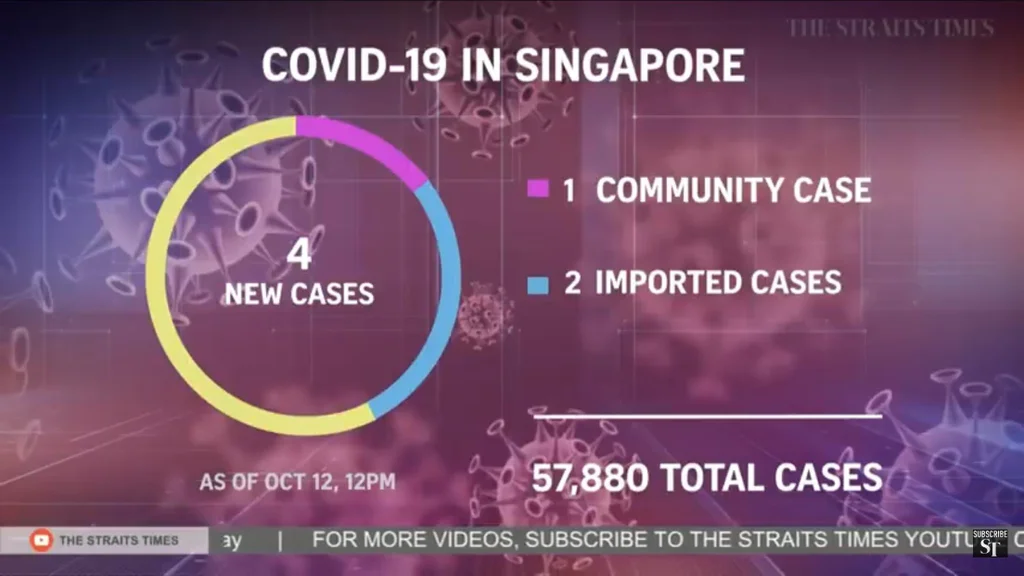

(from [r/dataisugly](https://www.reddit.com/r/dataisugly/comments/jbifom/this_was_from_a_news_source/))
Just everything about this graph is wrong. I don't know what yellow means, if it's the 4 new cases or if the whole chart is for 4 new cases, in which case, why is yellow more than half the chart? 